In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [44]:
def getSymbolReport(symbol:str) -> str:
    """
    Get required financial report for the desired symbol.
    symbol: Symbol
    """
    ticker = yf.Ticker(symbol)
    info_dict = ticker.get_info()
    news_list = ticker.get_news()
    institutional_holders = ticker.get_institutional_holders()
    mutualfund_holders = ticker.get_mutualfund_holders()   
    ann_income_stmt = ticker.get_income_stmt()
    qua_income_stmt = ticker.quarterly_income_stmt
    ann_balance_sheet = ticker.get_balance_sheet()
    qua_balance_sheet = ticker.quarterly_balance_sheet

    def getCompanyInfo(info_dict:dict) -> str: 

        sel_fields = ['longName','website','sector','industry','longBusinessSummary','fullTimeEmployees','companyOfficers']
        s = f"## **{info_dict['longName']}**<br>\n"
        for field in sel_fields:
            if field == 'longBusinessSummary':
                s += f"\n### **Business Summary**<br>\n{info_dict[field]}"
                continue
            elif field == 'fullTimeEmployees':
                s += "\n### **Employee Details**<br>\n"
            elif field == 'companyOfficers':
                s += 'majorEmployees:<br>\n'
                for officer in info_dict['companyOfficers']:
                    s += f"- {officer['name']}: {officer['title']}<br>\n"
                continue
            s += f"{field}: " + str(info_dict[field]) + "<br>\n"
        return s
    
    def getCompanyNews(news_list:list) -> str:

        sel_fields = ['title','link','publisher']
        s = f"### **Recent Company News**<br>\n"
        for news in news_list:
            for field in sel_fields:
                s += f"{field}: " + f"{news[field]}<br>\n"
            s += "<br>\n"
        return s
    
    def getInvestorData(df1:pd.DataFrame, df2:pd.DataFrame) -> str:

        # Institutional Holders and Percentage Holding
        plt.figure(figsize=(15,5))
        plt.title('Institutional Holders and Percentage Holding')
        plt.pie(df1['Shares'],normalize=True,labels=df1['Holder'])
        plt.pie(df1['Shares'],normalize=True,labels=round((df1['Shares']/df1['Shares'].sum())*100,3),labeldistance=0.5,rotatelabels=True)
        plt.savefig('./ReportMedia/Institutional_Holders_and_Percentage_Holding.png')
        
        # Mutual_Fund_Holders_and_Percentage_Holding
        plt.figure(figsize=(15,5))
        plt.title('Mutual Fund Holders and Percentage Holding')
        plt.pie(df2['Shares'],normalize=True,labels=df2['Holder'])
        plt.pie(df2['Shares'],normalize=True,labels=round((df2['Shares']/df2['Shares'].sum())*100,3),labeldistance=0.5,rotatelabels=True)
        plt.savefig('./ReportMedia/Mutual_Fund_Holders_and_Percentage_Holding.png')

        s = "### **Investor Data**<br>\n![Institutional Holders and Percentage Holding](./ReportMedia/Institutional_Holders_and_Percentage_Holding.png)<br>\n![Mutual_Fund_Holders_and_Percentage_Holding](./ReportMedia/Mutual_Fund_Holders_and_Percentage_Holding.png)<br>\n"
        return s
    
    def getFinancials(df1:dict, df2:pd.DataFrame, df3:pd.DataFrame, df4:pd.DataFrame, df5:pd.DataFrame):
        sel_fields1 = ['totalRevenue','totalDebt','totalCash','enterpriseValue','bookValue','marketCap','currentRatio','quickRatio'] # 'debtToEquity','dividendRate','dividendYield','fiveYearAvgDividendYield','earningsGrowth','earningsQuarterlyGrowth','enterpriseToEbitda','enterpriseToRevenue','payoutRatio','priceToBook','profitMargins','returnOnAssets','returnOnEquity','revenueGrowth','revenuePerShare','totalCashPerShare']
        sel_fields2 = ['EBITDA','EBIT','InterestExpense','InterestIncome','TotalExpenses','NetIncome','TotalRevenue','GrossProfit','BasicEPS','ResearchAndDevelopment']
        s = '### **Latest Financials**<br>\n#### General Financials<br>\n'
        for field in sel_fields1:
            if field == 'currentRatio':
                s += '#### Liquidity Ratios<br>\n'
                ann_current_ratio = 0
                qua_current_ratio = 0
                if 'CurrentAssets' in df4.index and 'CurrentLiabilities' in df4.index:
                    ann_current_ratio = 1                    
                if 'Current Assets' in df5.index and 'Current Liabilities' in df5.index:
                    qua_current_ratio = 1
                
                if ann_current_ratio and qua_current_ratio:
                    fig,ax = plt.subplots(1,2,sharey=True, figsize=(10,5))
                    ax[0].set_title('Annual Current Ratio')
                    ax[0].plot(df4.columns, np.array(df4.loc['CurrentAssets'])/np.array(df4.loc['CurrentLiabilities']))
                    ax[0].set_xlabel('Time Instance')
                    ax[0].set_ylabel('Current Ratio')

                    fig.suptitle('Current Ratio')
                    ax[1].set_title('Quarterly Current Ratio')
                    ax[1].plot(df5.columns, np.array(df5.loc['Current Assets'])/np.array(df5.loc['Current Liabilities']))
                    ax[1].set_xlabel('Time Instance')
                    plt.savefig('./ReportMedia/Current_Ratio.png')
                    s += "![Current Ratio](./ReportMedia/Current_Ratio.png)<br>\n"

                elif ann_current_ratio:
                    plt.figure(figsize=(10,5))
                    plt.title('Annual Current Ratio')
                    plt.plot(df4.columns, np.array(df4.loc['CurrentAssets'])/np.array(df4.loc['CurrentLiabilities']))
                    plt.xlabel('Time Instance')
                    plt.ylabel('Current Ratio')
                    plt.savefig('./ReportMedia/Current_Ratio.png')
                    s += "![Current Ratio](./ReportMedia/Current_Ratio.png)<br>\n"
                
                elif qua_current_ratio:
                    plt.figure(figsize=(10,5))
                    plt.title('Quarterly Current Ratio')
                    plt.plot(df5.columns, np.array(df5.loc['Current Assets'])/np.array(df5.loc['Current Liabilities']))
                    plt.xlabel('Time Instance')
                    plt.ylabel('Current Ratio')
                    plt.savefig('./ReportMedia/Current_Ratio.png')
                    s += "![Current Ratio](./ReportMedia/Current_Ratio.png)<br>\n"
                
                else:
                    s += f'Historical Data Unavailable. Recent Current Ratio: {df1['currentRatio']}<br>\n'
            
            elif field == 'quickRatio':
                fields = ['CurrentAssets', 'CurrentLiabilities','Inventory','PrepaidAssets','OtherCurrentAssets']
                fields1 = ['Current Assets', 'Current Liabilities','Inventory','Prepaid Assets','Other Current Assets']
                ann_quick_ratio = []
                qua_quick_ratio = []
                for index,i in enumerate(fields):
                    if i in df4.index:
                        ann_quick_ratio.append(index)
                for index,i in enumerate(fields1):
                    if i in df5.index:
                        qua_quick_ratio.append(index)
                
                if len(ann_quick_ratio) == 5  and len(qua_quick_ratio) == 5:
                    fig,ax = plt.subplots(1,2,sharey=True, figsize=(10,5))
                    fig.suptitle('Quick Ratio')
                    ax[0].set_title('Annual Quick Ratio')
                    ax[0].plot(df4.columns, (np.array(df4.loc['CurrentAssets']) - np.array(df4.loc['Inventory']) - np.array(df4.loc['PrepaidAssets']) - np.array(df4.loc['OtherCurrentAssets']))/np.array(df4.loc['CurrentLiabilities']))
                    ax[0].set_xlabel('Time Instance')
                    ax[0].set_ylabel('Quick Ratio')

                    ax[1].set_title('Quarterly Quick Ratio')
                    ax[1].plot(df5.columns, (np.array(df5.loc['Current Assets']) - np.array(df5.loc['Inventory']) - np.array(df5.loc['Prepaid Assets']) - np.array(df5.loc['Other Current Assets']))/np.array(df5.loc['Current Liabilities']))
                    ax[1].set_xlabel('Time Instance')
                    ax[1].set_ylabel('Quick Ratio')
                    plt.savefig('./ReportMedia/Quick_Ratio.png')
                    s += "![Quick Ratio](./ReportMedia/Quick_Ratio.png)<br>\n"

                elif ([i in ann_quick_ratio for i in [0,1,2,4]] == 4*[True]) and ([i in qua_quick_ratio for i in [0,1,2,4]] == 4*[True]):
                    fig,ax = plt.subplots(1,2,sharey=True, figsize=(10,5))
                    fig.suptitle('Quick Ratio')
                    ax[0].set_title('Annual Quick Ratio')
                    ax[0].plot(df4.columns, (np.array(df4.loc['CurrentAssets']) - np.array(df4.loc['Inventory']) - np.array(df4.loc['OtherCurrentAssets']))/np.array(df4.loc['CurrentLiabilities']))
                    ax[0].set_xlabel('Time Instance')
                    ax[0].set_ylabel('Quick Ratio')

                    ax[1].set_title('Quarterly Quick Ratio')
                    ax[1].plot(df5.columns, (np.array(df5.loc['Current Assets']) - np.array(df5.loc['Inventory']) - np.array(df5.loc['Other Current Assets']))/np.array(df5.loc['Current Liabilities']))
                    ax[1].set_xlabel('Time Instance')
                    ax[1].set_ylabel('Quick Ratio')
                    plt.savefig('./ReportMedia/Quick_Ratio.png')
                    s += "![Quick Ratio](./ReportMedia/Quick_Ratio.png)<br>\n"
                
                elif ([i in ann_quick_ratio for i in [0,1,3,4]] == 4*[True]) and ([i in qua_quick_ratio for i in [0,1,3,4]] == 4*[True]):
                    fig,ax = plt.subplots(1,2,sharey=True, figsize=(10,5))
                    fig.suptitle('Quick Ratio')
                    ax[0].set_title('Annual Quick Ratio')
                    ax[0].plot(df4.columns, (np.array(df4.loc['CurrentAssets']) - np.array(df4.loc['PrepaidAssets']) - np.array(df4.loc['OtherCurrentAssets']))/np.array(df4.loc['CurrentLiabilities']))
                    ax[0].set_xlabel('Time Instance')
                    ax[0].set_ylabel('Quick Ratio')

                    ax[1].set_title('Quarterly Quick Ratio')
                    ax[1].plot(df5.columns, (np.array(df5.loc['Current Assets']) - np.array(df5.loc['Prepaid Assets']) - np.array(df5.loc['Other Current Assets']))/np.array(df5.loc['Current Liabilities']))
                    ax[1].set_xlabel('Time Instance')
                    ax[1].set_ylabel('Quick Ratio')
                    plt.savefig('./ReportMedia/Quick_Ratio.png')
                    s += "![Quick Ratio](./ReportMedia/Quick_Ratio.png)<br>\n"

                elif ([i in ann_quick_ratio for i in [0,1,4]] == 4*[True]) and ([i in qua_quick_ratio for i in [0,1,4]] == 4*[True]):
                    fig,ax = plt.subplots(1,2,sharey=True, figsize=(10,5))
                    fig.suptitle('Quick Ratio')
                    ax[0].set_title('Annual Quick Ratio')
                    ax[0].plot(df4.columns, (np.array(df4.loc['CurrentAssets']) - np.array(df4.loc['OtherCurrentAssets']))/np.array(df4.loc['CurrentLiabilities']))
                    ax[0].set_xlabel('Time Instance')
                    ax[0].set_ylabel('Quick Ratio')

                    ax[1].set_title('Quarterly Quick Ratio')
                    ax[1].plot(df5.columns, (np.array(df5.loc['Current Assets']) - np.array(df5.loc['Other Current Assets']))/np.array(df5.loc['Current Liabilities']))
                    ax[1].set_xlabel('Time Instance')
                    ax[1].set_ylabel('Quick Ratio')
                    plt.savefig('./ReportMedia/Quick_Ratio.png')
                    s += "![Quick Ratio](./ReportMedia/Quick_Ratio.png)<br>\n"
                
                else:
                    s += f'Historical Data Unavailable. Recent Quick Ratio: {df1['quickRatio']}<br>\n'
            elif field == 'bookValue':
                s += f"{field}PerShare: " + f"{df1[field]}<br>\n"
            elif field == 'enterpriseValue':
                s += f"{field}: " + f"{df1[field] if df1[field] > 0 else df1['marketCap'] + df1['totalDebt'] - df5.loc['Cash And Cash Equivalents'].iloc[0]}<br>\n"
            else:
                s += f"{field}: " + f"{df1[field]}<br>\n"
        return s

    return getCompanyInfo(info_dict = info_dict) + getCompanyNews(news_list = news_list) + getInvestorData(df1 = institutional_holders, df2 = mutualfund_holders) + getFinancials(df1 = info_dict, df2 = ann_income_stmt, df3 = qua_income_stmt, df4 = ann_balance_sheet, df5 = qua_balance_sheet)

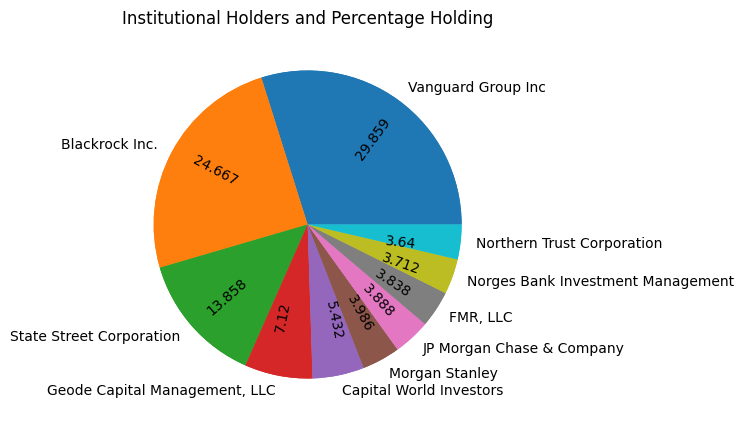

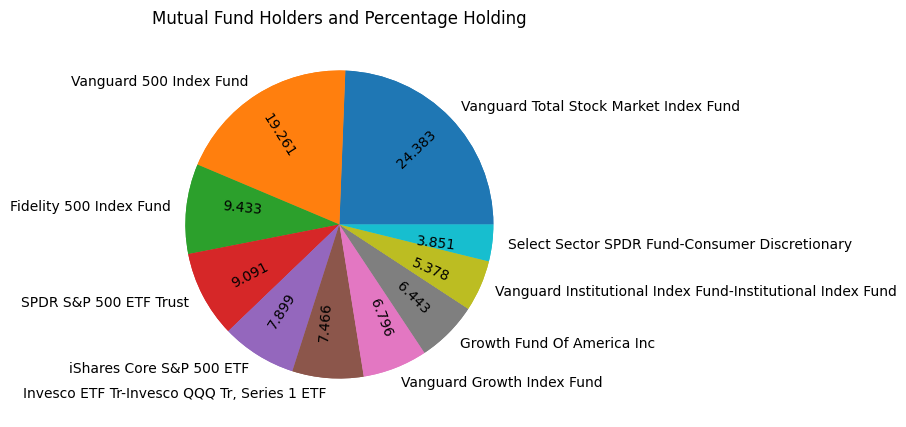

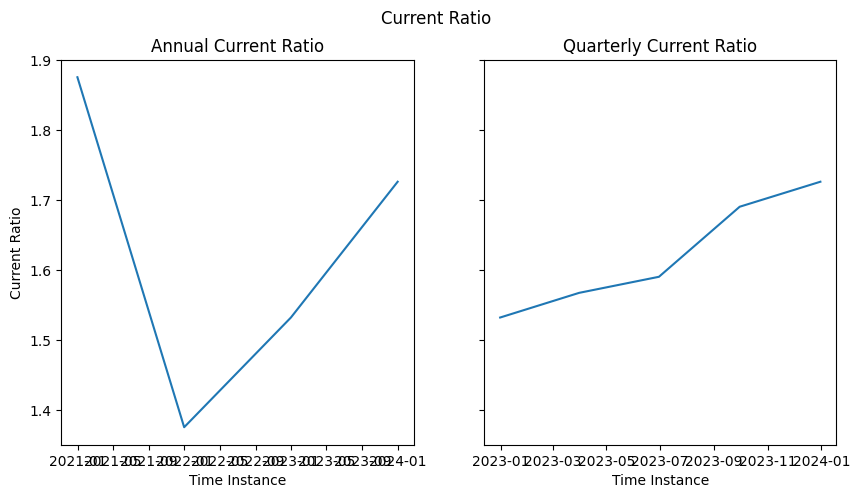

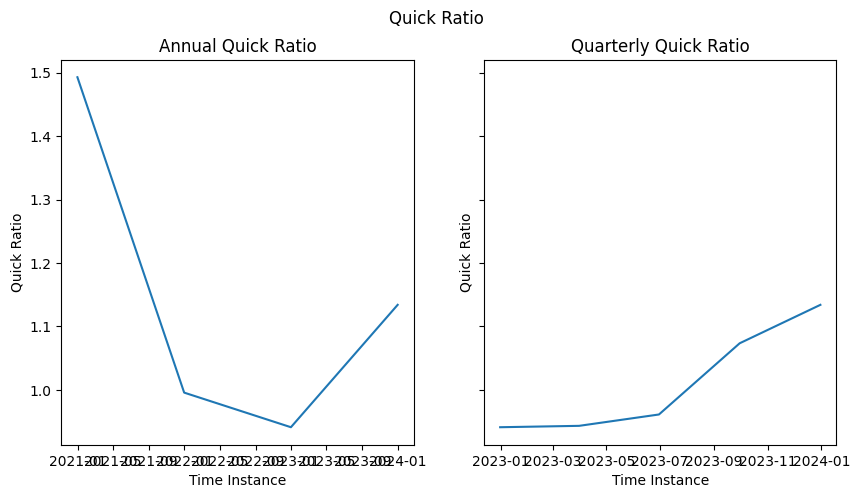

In [49]:
symbol = 'TSLA'
with open('Report.md','w') as file:
    file.write(getSymbolReport(symbol = symbol))
file.close()

## **Tesla, Inc.**<br>
longName: Tesla, Inc.<br>
website: https://www.tesla.com<br>
sector: Consumer Cyclical<br>
industry: Auto Manufacturers<br>

### **Business Summary**<br>
Tesla, Inc. designs, develops, manufactures, leases, and sells electric vehicles, and energy generation and storage systems in the United States, China, and internationally. The company operates in two segments, Automotive, and Energy Generation and Storage. The Automotive segment offers electric vehicles, as well as sells automotive regulatory credits; and non-warranty after-sales vehicle, used vehicles, body shop and parts, supercharging, retail merchandise, and vehicle insurance services. This segment also provides sedans and sport utility vehicles through direct and used vehicle sales, a network of Tesla Superchargers, and in-app upgrades; purchase financing and leasing services; services for electric vehicles through its company-owned service locations and Tesla mobile service technicians; and vehicle limited warranties and extended service plans. The Energy Generation and Storage segment engages in the design, manufacture, installation, sale, and leasing of solar energy generation and energy storage products, and related services to residential, commercial, and industrial customers and utilities through its website, stores, and galleries, as well as through a network of channel partners; and provision of service and repairs to its energy product customers, including under warranty, as well as various financing options to its solar customers. The company was formerly known as Tesla Motors, Inc. and changed its name to Tesla, Inc. in February 2017. Tesla, Inc. was incorporated in 2003 and is headquartered in Austin, Texas.
### **Employee Details**<br>
fullTimeEmployees: 140473<br>
majorEmployees:<br>
- Mr. Elon R. Musk: Technoking of Tesla, CEO & Director<br>
- Mr. Andrew D. Baglino: Senior Vice President of Powertrain & Energy Engineering<br>
- Mr. Vaibhav  Taneja: CFO, Corporate Controller & Chief Accounting Officer<br>
- Mr. Martin  Viecha: Senior Director for Investor Relations<br>
- Brian  Scelfo: Senior Director of Corporate Development<br>
- Mr. Jeffrey Brian Straubel: Independent Director<br>
- Mr. Franz  von Holzhausen: Chief Designer<br>
- Mr. Xiaotong  Zhu: Senior Vice President of Automotive<br>
- Mr. John  Walker: Vice President of Sales - North America<br>
- Mr. Peter  Bannon: Chip Architect<br>
### **Recent Company News**<br>
title: Elon Musk Wants to Move Tesla�s Incorporation From Delaware to Texas<br>
link: https://finance.yahoo.com/m/808f2211-dea2-3c34-8270-e49473b64355/elon-musk-wants-to-move.html<br>
publisher: The Wall Street Journal<br>
<br>
title: The Lawyer�and Drummer�Who Felled Elon Musk�s $55.8 Billion Compensation Package<br>
link: https://finance.yahoo.com/m/caa716e1-e3eb-382f-9221-628e2e5d638d/the-lawyer%E2%80%94and-drummer%E2%80%94who.html<br>
publisher: The Wall Street Journal<br>
<br>
title: US STOCKS-Futures climb following Wall St selloff after Fed holds rates steady<br>
link: https://finance.yahoo.com/news/us-stocks-futures-climb-following-122358881.html<br>
publisher: Reuters<br>
<br>
title: Deliveries for NIO, XPeng, and Li Auto Crater. Not Great News for Tesla. So Why Are the Stocks Rising?<br>
link: https://finance.yahoo.com/m/fb9dc7f7-0712-3182-86ea-2e8ca97a53ca/deliveries-for-nio%2C-xpeng%2C.html<br>
publisher: Barrons.com<br>
<br>
title: Tesla Full Year 2023 Earnings: EPS Beats Expectations<br>
link: https://finance.yahoo.com/news/tesla-full-2023-earnings-eps-114607342.html<br>
publisher: Simply Wall St.<br>
<br>
title: China EV Sales For Li Auto, BYD Tumble; Tesla Offers Fresh Discounts<br>
link: https://finance.yahoo.com/m/da6da17c-f136-3da4-8351-9eef64c7dd75/china-ev-sales-for-li-auto%2C.html<br>
publisher: Investor's Business Daily<br>
<br>
title: Ford Has an All-New Explorer. It Isn�t Electric but It�s Smart.<br>
link: https://finance.yahoo.com/m/97486bcf-a2be-3c4f-8130-306c217882f2/ford-has-an-all-new-explorer..html<br>
publisher: Barrons.com<br>
<br>
title: Musk wants Tesla investors to vote on switching the carmaker's corporate registration to Texas<br>
link: https://finance.yahoo.com/news/musk-wants-tesla-investors-vote-104927644.html<br>
publisher: Associated Press Finance<br>
<br>
### **Investor Data**<br>
![Institutional Holders and Percentage Holding](./ReportMedia/Institutional_Holders_and_Percentage_Holding.png)<br>
![Mutual_Fund_Holders_and_Percentage_Holding](./ReportMedia/Mutual_Fund_Holders_and_Percentage_Holding.png)<br>
### **Latest Financials**<br>
#### General Financials<br>
totalRevenue: 96772997120<br>
totalDebt: 9573000192<br>
totalCash: 29094000640<br>
enterpriseValue: 577933410304<br>
bookValuePerShare: 19.665<br>
marketCap: 596479311872<br>
#### Liquidity Ratios<br>
![Current Ratio](./ReportMedia/Current_Ratio.png)<br>
![Quick Ratio](./ReportMedia/Quick_Ratio.png)<br>
